In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical

In [9]:
train_path = '/kaggle/input/tiny-dataset-imagent/tiny-imagenet-200/train'
val_path = '/kaggle/input/tiny-dataset-imagent/tiny-imagenet-200/val'
test_path = '/kaggle/input/tiny-dataset-imagent/tiny-imagenet-200/test'

print(os.listdir(train_path))

['n02437312', 'n03976657', 'n07753592', 'n02769748', 'n02730930', 'n04465501', 'n02950826', 'n02002724', 'n04532106', 'n02793495', 'n02999410', 'n09332890', 'n03854065', 'n04399382', 'n02056570', 'n04398044', 'n04540053', 'n02058221', 'n04023962', 'n03400231', 'n03838899', 'n04265275', 'n02802426', 'n04149813', 'n02917067', 'n01950731', 'n03085013', 'n04487081', 'n03992509', 'n02279972', 'n07873807', 'n07875152', 'n03599486', 'n04259630', 'n07715103', 'n04501370', 'n09428293', 'n04254777', 'n03770439', 'n03649909', 'n07614500', 'n01882714', 'n01698640', 'n04328186', 'n02699494', 'n02963159', 'n01641577', 'n07747607', 'n03983396', 'n02395406', 'n01774750', 'n03026506', 'n03160309', 'n01855672', 'n03662601', 'n04251144', 'n03255030', 'n02666196', 'n02988304', 'n04275548', 'n03670208', 'n01768244', 'n02132136', 'n07583066', 'n01944390', 'n03388043', 'n02085620', 'n03617480', 'n02795169', 'n04074963', 'n02364673', 'n02823428', 'n02841315', 'n01983481', 'n04596742', 'n07734744', 'n04371430'

In [10]:
def process_image_file(file_path, label, img_size=(64, 64)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

def load_dataset(dataset_path, label_to_index, split='train', img_size=(64, 64)):
    images, labels = [], []

    if split == 'train':
        for label in label_to_index.keys():
            pattern = os.path.join(dataset_path, label, 'images/*.JPEG')
            for file_path in tf.io.gfile.glob(pattern):
                img, lbl = process_image_file(file_path, label_to_index[label], img_size)
                images.append(img)
                labels.append(lbl)
    elif split == 'val':
        val_annotations_path = os.path.join(dataset_path, 'val_annotations.txt')
        img_label_map = {}
        with open(val_annotations_path, 'r') as f:
            for line in f:
                img_file, label = line.strip().split('\t')[:2]
                if label in label_to_index:
                    img_label_map[img_file] = label_to_index[label]

        images_dir = os.path.join(dataset_path, 'images')
        for img_file, label_idx in img_label_map.items():
            file_path = os.path.join(images_dir, img_file)
            img, lbl = process_image_file(file_path, label_idx, img_size)
            images.append(img)
            labels.append(lbl)

    images = tf.stack(images)
    labels = tf.stack(labels)

    return tf.data.Dataset.from_tensor_slices((images, labels))

num_classes=200

def one_hot_encode(image,label):
    return image, tf.one_hot(label, depth=num_classes)


class_dirs = os.listdir(train_path)
selected_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 
                    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
label_to_index = {label: idx for idx, label in enumerate(class_dirs) if label in selected_classes}

train_dataset = load_dataset(train_path, label_to_index, 'train').shuffle(1000).map(lambda x, y: (x, y))
val_dataset = load_dataset(val_path, label_to_index, 'val').map(lambda x, y: (x, y))

train_dataset = train_dataset.map(one_hot_encode)
val_dataset = val_dataset.map(one_hot_encode)

for image, label in train_dataset.take(1):
    print("Shape of image:", image.shape)
    print("Shape of label:", label)

Shape of image: (64, 64, 3)
Shape of label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(200,), dtype=float32)


In [11]:
#!pip install --upgrade tensorflow

def Alexnet_model(input_shape=(64, 64, 3), num_classes=10):
    model = Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1.0, alpha=0.00002, beta=0.75)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=2, bias=1.0, alpha=0.00002, beta=0.75)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Fourth Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Fifth Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flattening Layer
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [12]:
# Assuming train_dataset and val_dataset are defined and batched as shown earlier in the discussion

# Set environment variables and suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


batch_size = 32

# Prepare the training dataset
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Set the number of classes for the dataset
num_classes = 200

# Assuming you have a function named create_alexnet that returns the AlexNet model
alexnet_model = Alexnet_model(input_shape=(64, 64, 3), num_classes=num_classes)
k=5
# Compile the model
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', TopKCategoricalAccuracy(k=k)])

# Set up callbacks for saving the model and logging
checkpoint = ModelCheckpoint('alexnet_weights.keras', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs')

# Train the model using the dataset objects
history = alexnet_model.fit(
    train_dataset,
    epochs=120,
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard]
)


Epoch 1/120
  4/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1354 - loss: 11.3691 - top_k_categorical_accuracy: 0.4785     

I0000 00:00:1711476659.063066      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711476659.085817      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2007 - loss: 3.1227 - top_k_categorical_accuracy: 0.8332

W0000 00:00:1711476669.008158      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.2007 - loss: 3.1183 - top_k_categorical_accuracy: 0.8329 - val_accuracy: 0.1000 - val_loss: 2.7608 - val_top_k_categorical_accuracy: 0.5000
Epoch 2/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1630 - loss: 2.2287 - top_k_categorical_accuracy: 0.6916 - val_accuracy: 0.1000 - val_loss: 2.7485 - val_top_k_categorical_accuracy: 0.5000
Epoch 3/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1373 - loss: 2.2064 - top_k_categorical_accuracy: 0.6869 - val_accuracy: 0.1000 - val_loss: 2.7554 - val_top_k_categorical_accuracy: 0.5000
Epoch 4/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1398 - loss: 2.2827 - top_k_categorical_accuracy: 0.6159 - val_accuracy: 0.1000 - val_loss: 2.6594 - val_top_k_categorical_accuracy: 0.5000
Epoch 5/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1228 - loss: 2.2957 - top_k_categorical_accuracy: 0.5947 - val_accuracy: 0.1000 - val_loss: 2.7534 - val_top_k_

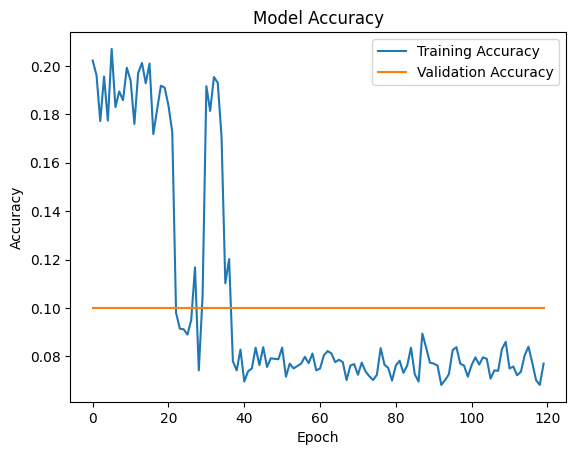

In [13]:
# Visualization of Training Results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

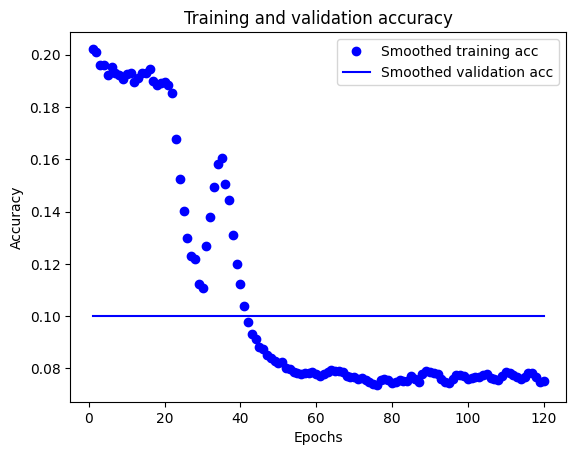

In [14]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Assuming history.history['accuracy'] and history.history['val_accuracy'] are lists of accuracy values
smoothed_training_accuracy = smooth_curve(history.history['accuracy'])
smoothed_validation_accuracy = smooth_curve(history.history['val_accuracy'])

plt.plot(range(1, len(smoothed_training_accuracy) + 1), smoothed_training_accuracy, 'bo', label='Smoothed training acc')
plt.plot(range(1, len(smoothed_validation_accuracy) + 1), smoothed_validation_accuracy, 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:

alexnet_results = alexnet_model.evaluate(val_dataset)

print("AlexNet Loss:", alexnet_results[0])
print("AlexNet Top-1 Accuracy:", alexnet_results[1])
print("AlexNet Top-k Accuracy:", alexnet_results[2])
print("AlexNet Top-k Error:", 1 - alexnet_results[2])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0937 - loss: 2.3055 - top_k_categorical_accuracy: 0.4734 
AlexNet Loss: 2.3035709857940674
AlexNet Top-1 Accuracy: 0.10000000149011612
AlexNet Top-k Accuracy: 0.5
AlexNet Top-k Error: 0.5
